## Rain Application Prediction Model

The goal of this notebook is to find a model that can predict the current chance of rain with minimal data. The data that can be used is only data that can be accessed from a smartwatch sensor. Features may include Barometer, Altimeter, and Temperature. Other features may be possible. The Basil dataset can be found at https://www.meteoblue.com/en/weather/archive/export?daterange=2022-01-01%20-%202023-10-10&locations%5B%5D=basel_switzerland_2661604&domain=ERA5T&min=2022-01-01&max=2023-10-10&params%5B%5D=&params%5B%5D=temp2m&params%5B%5D=&params%5B%5D=precip&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=pressure&params%5B%5D=&params%5B%5D=&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30. It is the feature discussed for the year 2022 al from one sensor.

The data in this notebook will be used in simplistic machine learning algorithms. The algorithms must be basic since they will be implemented on a smartwatch with CPU, Memory and Storage requirements are paramount. 

### Import Packages 

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

sns.set_palette('Set2')
sns.set_style('whitegrid')

### Read and Manipulate Raw Data

In [5]:
raw_data = pd.read_csv("Basel.csv")

In [6]:
raw_data = raw_data[9:]

In [7]:
raw_data.columns = ["datetime", "temp", "prec", "pressure"]

In [8]:
raw_data.head()

,datetime,temp,prec,pressure
9,20220101T0000,6.4902453,0.0,1028.4
10,20220101T0100,6.0602455,0.0,1028.8
11,20220101T0200,5.5602455,0.0,1029.0
12,20220101T0300,4.630245,0.0,1029.0
13,20220101T0400,3.6602454,0.0,1029.5


In [9]:
date_format = "%Y%m%dT%H%M"

raw_data['datetime'] = raw_data['datetime'].apply(lambda x: pd.to_datetime(x, format=date_format))


In [10]:
raw_data['temp'] = raw_data['temp'].astype("float").round(2)
raw_data['prec'] = raw_data['prec'].astype("float").round(0)
raw_data['pressure'] = raw_data['pressure'].astype("float")

In [11]:
raw_data.describe(include="all")

,datetime,temp,prec,pressure
count,15552,15338.000000,15338.000000,15338.000000
mean,2022-11-20 23:30:00.000000256,13.382370,0.058091,1018.376496
min,2022-01-01 00:00:00,-7.200000,0.000000,986.100000
25%,2022-06-11 23:45:00,6.980000,0.000000,1013.925000
50%,2022-11-20 23:30:00,13.230000,0.000000,1018.000000
75%,2023-05-01 23:15:00,19.360000,0.000000,1022.400000
max,2023-10-10 23:00:00,37.640000,8.000000,1041.900000
std,NaN,8.570233,0.293286,7.654312


In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15552 entries, 9 to 15560
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  15552 non-null  datetime64[ns]
 1   temp      15338 non-null  float64       
 2   prec      15338 non-null  float64       
 3   pressure  15338 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 486.1 KB


In [13]:
raw_data['isRain'] = np.where(raw_data['prec'] > 0, 1, 0)

In [14]:
raw_data.dropna(inplace=True)

### Exploratory Data Analysis

In [15]:
df = raw_data.copy()
df.head()

,datetime,temp,prec,pressure,isRain
9,2022-01-01 00:00:00,6.49,0.0,1028.4,0
10,2022-01-01 01:00:00,6.06,0.0,1028.8,0
11,2022-01-01 02:00:00,5.56,0.0,1029.0,0
12,2022-01-01 03:00:00,4.63,0.0,1029.0,0
13,2022-01-01 04:00:00,3.66,0.0,1029.5,0


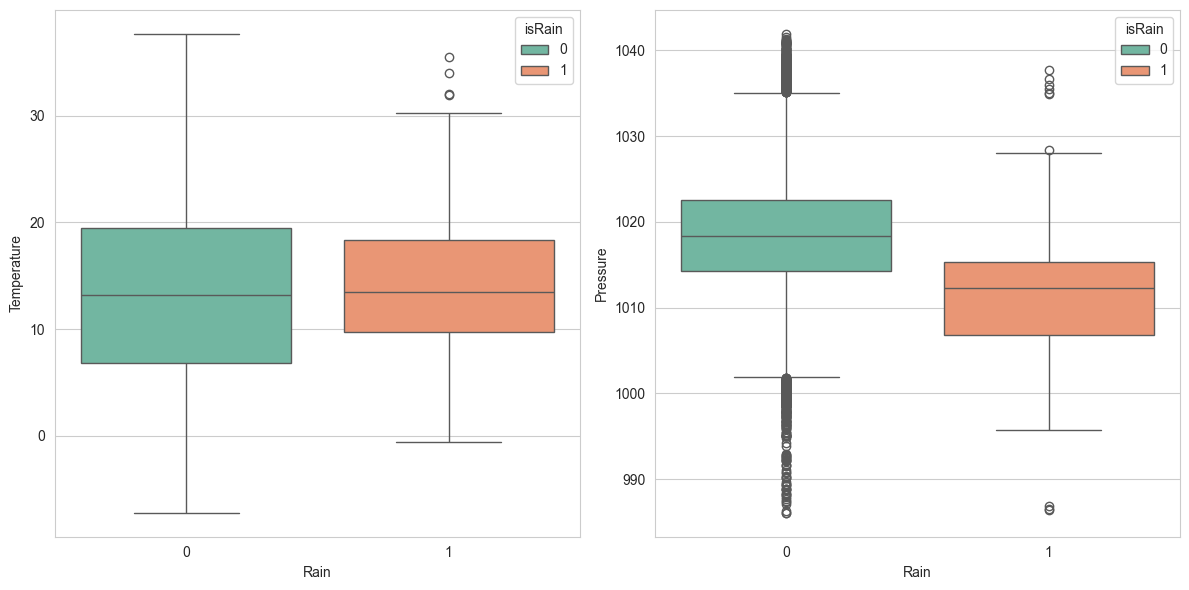

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=df, x = 'isRain', y = 'temp' ,hue='isRain', ax=axes[0])
axes[0].set_ylabel("Temperature")
axes[0].set_xlabel("Rain")

sns.boxplot(data=df, x = 'isRain', y = 'pressure', hue='isRain', ax=axes[1])
axes[1].set_ylabel('Pressure')
axes[1].set_xlabel('Rain')

# Adjust layout
plt.tight_layout()


In the plot above we can see that barometric pressure has a significant effect on precipitation however temperature does not. 


### Feature Engineering

We can try to find a polynomial effect, but first we account for values near and below 0 in the temperature feature.

In [17]:
#create a base term to shift the low point
min_val = abs(df['temp'].min() - 1)
print(min_val)
df["temp_pressure"] = df['pressure'] / (df['temp'] + min_val)
df["temp_pressure"].describe()

8.2


count    15338.000000
mean        59.720412
std         44.108106
min         21.987347
25%         36.871788
50%         47.482566
75%         67.087709
max       1009.300000
Name: temp_pressure, dtype: float64

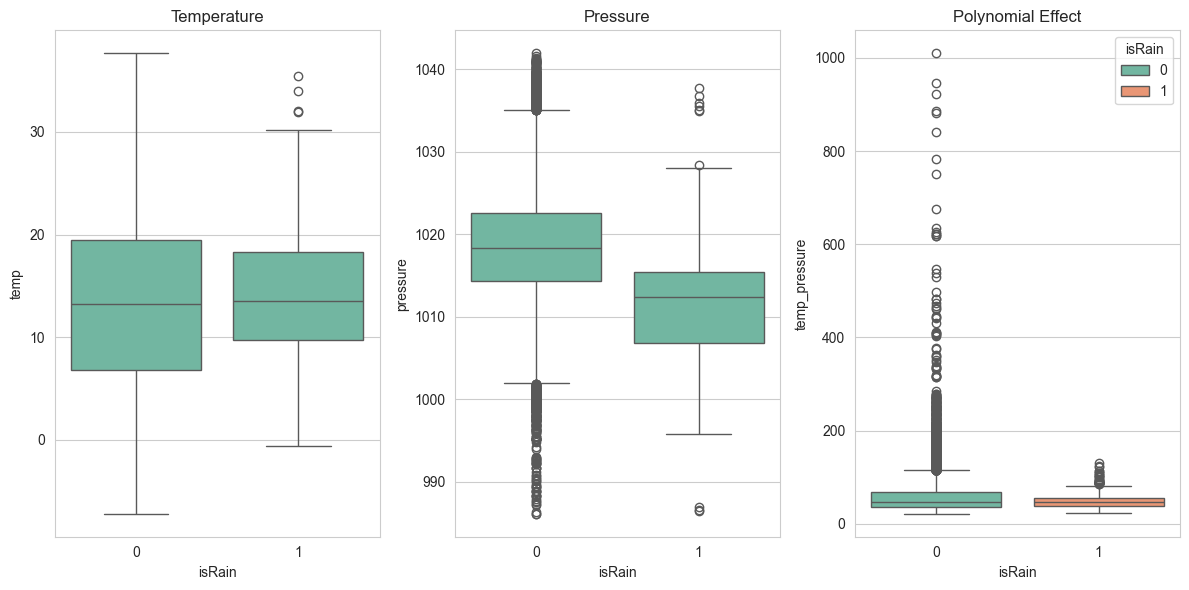

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=df, x = 'isRain', y = 'temp', ax=axes[0])
axes[0].set_title('Temperature')

sns.boxplot(data=df, x = 'isRain', y = 'pressure',  ax=axes[1])
axes[1].set_title('Pressure')

sns.boxplot(data=df, x = 'isRain', y = 'temp_pressure', hue='isRain', ax=axes[2])
axes[2].set_title('Polynomial Effect')

# Adjust layout
plt.tight_layout()

The polynomial effect does look like it adds some value to the model and will be included. Another metric that could be usefule is the change in temperature and the change in pressure. Currently temperature does not have any value to tether it to this model. For instance a low temperature durin summer and a high temperature in winter mean the same thing, but their context is significantly different. By adding a change from the previous recorder value we add a current context tot he model and something can be replicated in storage on mobile devices.


In [19]:
df['previous_temp'] = df['temp'].shift(1)
df['previous_pressure'] = df['pressure'].shift(1)
df=df[1:]
df['change_temp'] = df['temp'] - df['previous_temp']
df['change_pressure'] = df['pressure'] - df['previous_pressure']
df.head()

,datetime,temp,prec,pressure,isRain,temp_pressure,previous_temp,previous_pressure,change_temp,change_pressure
10,2022-01-01 01:00:00,6.06,0.0,1028.8,0,72.145863,6.49,1028.4,-0.43,0.4
11,2022-01-01 02:00:00,5.56,0.0,1029.0,0,74.781977,6.06,1028.8,-0.50,0.2
12,2022-01-01 03:00:00,4.63,0.0,1029.0,0,80.202650,5.56,1029.0,-0.93,0.0
13,2022-01-01 04:00:00,3.66,0.0,1029.5,0,86.804384,4.63,1029.0,-0.97,0.5
14,2022-01-01 05:00:00,3.88,0.0,1029.5,0,85.223510,3.66,1029.5,0.22,0.0


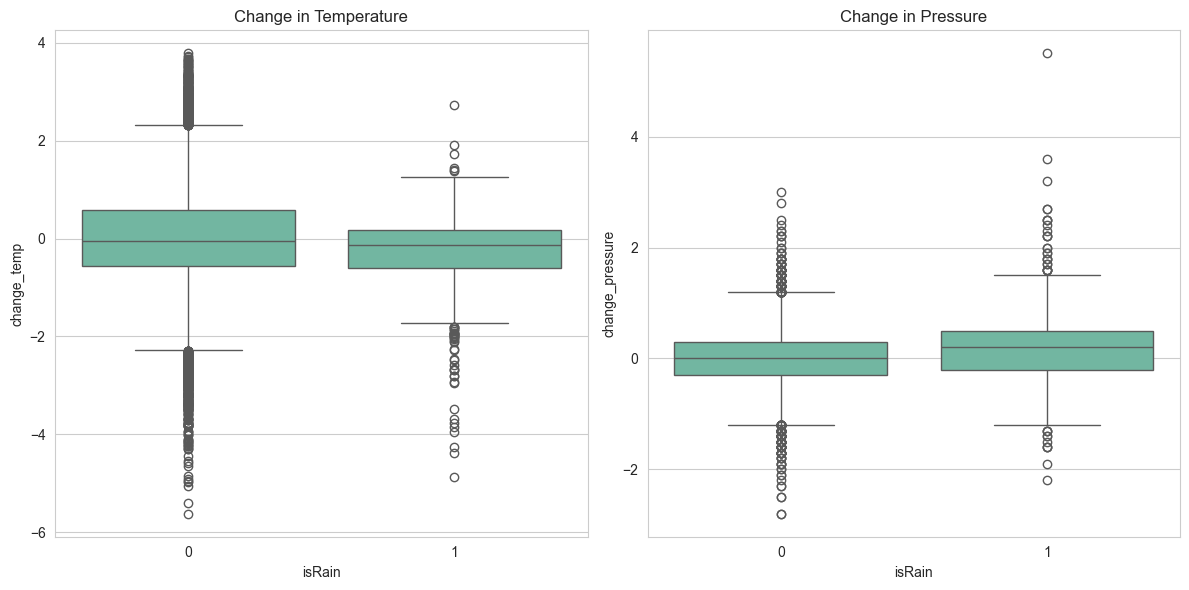

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=df, x = 'isRain', y = 'change_temp', ax=axes[0])
axes[0].set_title('Change in Temperature')

sns.boxplot(data=df, x = 'isRain', y = 'change_pressure',  ax=axes[1])
axes[1].set_title('Change in Pressure')

# Adjust layout
plt.tight_layout()

In [21]:
df.describe()

,datetime,temp,prec,pressure,isRain,temp_pressure,previous_temp,previous_pressure,change_temp,change_pressure
count,15337,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000
mean,2022-11-16 13:00:00,13.382819,0.058095,1018.375843,0.047076,59.719741,13.382338,1018.376091,0.000481,-0.000248
min,2022-01-01 01:00:00,-7.200000,0.000000,986.100000,0.000000,21.987347,-7.200000,986.100000,-5.620000,-2.800000
25%,2022-06-09 19:00:00,6.980000,0.000000,1013.900000,0.000000,36.870944,6.980000,1013.900000,-0.560000,-0.300000
50%,2022-11-16 13:00:00,13.230000,0.000000,1018.000000,0.000000,47.482550,13.230000,1018.000000,-0.060000,0.000000
75%,2023-04-25 07:00:00,19.360000,0.000000,1022.400000,0.000000,67.085261,19.360000,1022.400000,0.560000,0.300000
max,2023-10-02 01:00:00,37.640000,8.000000,1041.900000,1.000000,1009.300000,37.640000,1041.900000,3.780000,5.500000
std,NaN,8.570332,0.293296,7.654133,0.211808,44.109466,8.570512,7.654396,1.088020,0.480986


In [22]:
# pressure_min = abs(df['change_pressure'].min()) + 1
# df['pressure_poly'] = df['change_pressure'] + pressure_min
# df['pressure_poly'] = df['pressure'] * df['pressure_poly']  

In [23]:
df['pressure_binary'] = np.where(df['change_pressure'] >=0, 1, 0)

In [24]:
count_table = df.pivot_table(index='pressure_binary', columns='isRain', aggfunc='size', fill_value=0)
count_table

isRain,0,1
pressure_binary,,
0,6725,245
1,7890,477


There seems to be very little effect of the polynomial here but we can attempt it in our model and see if we can get a better result

### Outliers

Another important metric we need to account for is outliers. In the final application we should disguard outliers that are source from our sensors as invalid measurements and display an alert of some type. Below we will research and define outliers based on the data we collected.

In [106]:
q25, median, q75 = np.percentile(df['temp'], [25,50,75])
iqr = q75 - q25
print(f"1% quartile for temperature: {q25}")
print(f"99% quartile for temperature: {q75}")
print(f"Median temperature: {median}")
print(f"IQR of temperature: {iqr}") 

1% quartile for temperature: 6.98
99% quartile for temperature: 19.36
Median temperature: 13.23
IQR of temperature: 12.379999999999999


The temperature metric does not have a realistic high and low point. We consider all the points valid within this dataset and we will need to consult other documentation to determine minimum and maximum allowed metrics.

In [107]:
q25, median, q75 = np.percentile(df['pressure'], [25,50,75])
iqr = q75 - q25
print(f"1% quartile for Pressure: {q25}")
print(f"99% quartile for Pressure: {q75}")
print(f"Median Pressure: {median}")
print(f"IQR of Pressure: {iqr}") 

1% quartile for Pressure: 1013.9
99% quartile for Pressure: 1022.4
Median Pressure: 1018.0
IQR of Pressure: 8.5


These values are all also acceptable and outside dources will need to be referenced.

In [27]:
# Check class imbalance
df['isRain'].value_counts(normalize=True)

isRain
0    0.952924
1    0.047076
Name: proportion, dtype: float64

Since this is an imbalanced dataset we will need to upsample the rain examples to ensure a more representable model.

### Modeling

In [28]:
X = df[['temp', 'pressure', 'temp_pressure']]
y = np.ravel(df['isRain'])

In [29]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [30]:
x_train, x_test, y_train,  y_test = train_test_split(X, y, stratify= y, random_state=123)

print(f'X Train: {x_train.shape}')
print(f'X Test: {x_test.shape}')
print(f'Y Train: {y_train.shape}')
print(f'Y Test: {y_test.shape}')


X Train: (11502, 3)
X Test: (3835, 3)
Y Train: (11502,)
Y Test: (3835,)


In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=123)
x_train, y_train = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train).value_counts(normalize=True)

0    0.5
1    0.5
Name: proportion, dtype: float64

#### Logistic Regression

In [32]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [33]:
log_reg.coef_

array([[-2.15562809, -1.23863358, -2.05049786]])

In [34]:
log_reg.score(x_train, y_train)

0.7451418666180093

In [35]:
y_pred = log_reg.predict(x_test)

In [36]:
log_reg.score(x_test,y_test)

0.7105606258148631

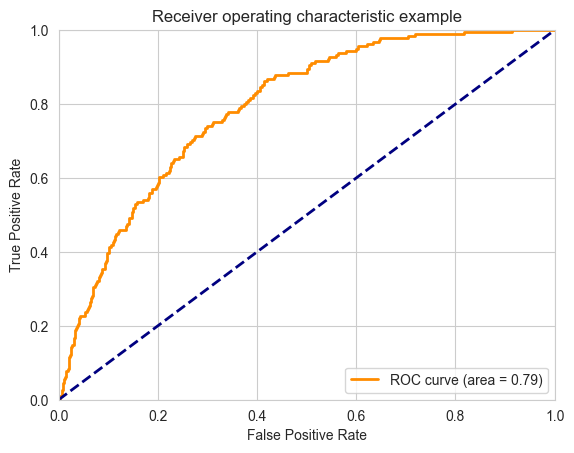

In [37]:
from sklearn import metrics

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = log_reg.predict_proba(x_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [39]:
log_reg = LogisticRegression(random_state=123)

# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create GridSearchCV object
log_search = GridSearchCV(log_reg, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit GridSearchCV object to the data
log_search.fit(x_train, y_train)

# Print best parameters and score
print("Best parameters:", log_search.best_params_)
print("Best score:", log_search.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'C': 0.01}
Best score: 0.7528059585742292


In [40]:
y_pred = log_search.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75     10961
           1       0.74      0.78      0.76     10961

    accuracy                           0.75     21922
   macro avg       0.75      0.75      0.75     21922
weighted avg       0.75      0.75      0.75     21922



### Random Forest Classifier

In [41]:
%%time 

rfc = RandomForestClassifier(random_state=123)

# Define the pipeline with RFE
rf_pipeline = Pipeline([
    ('rfc', rfc)
])

ps = np.arange(4,12,2)
param_grid = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_depth': ps,
    'rfc__min_samples_leaf': ps,
    'rfc__n_estimators': [20,40,80,100]
}

# Perform randomized search using the defined pipeline and parameter grid
rf_search = GridSearchCV(rf_pipeline, param_grid=param_grid, cv=5, scoring='accuracy',\
                                 n_jobs=6)

# Fit the search on the training data using the combined weights
rf_search.fit(x_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {rf_search.best_params_}")
print(f"Mean Accuracy score: {np.mean(rf_search.cv_results_['mean_test_score']).round(2)}")

Best parameters: {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 4, 'rfc__n_estimators': 20}
Mean Accuracy score: 0.79
CPU times: user 1.85 s, sys: 466 ms, total: 2.32 s
Wall time: 1min 17s


In [42]:
y_pred = rf_search.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84     10961
           1       0.82      0.88      0.85     10961

    accuracy                           0.84     21922
   macro avg       0.84      0.84      0.84     21922
weighted avg       0.84      0.84      0.84     21922



### Extreme Gradient Boost Classifier

In [53]:
%%time 
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=123)

# Define the pipeline
xgb_pipeline = Pipeline([
    ('xgbc', xgb)
])

param_grid = {
    'xgbc__max_depth': np.arange(2,6,1),
    'xgbc__learning_rate': [.001, 0.01, 0.1],
    'xgbc__subsample': [0.3, 0.5, 0.7],
    'xgbc__colsample_bytree': [0.3, 0.5, 0.7],
    'xgbc__n_estimators': [20,40,80, 100,150, 200]
}

# random search using the defined pipeline and parameter grid
xgb_search = GridSearchCV(xgb_pipeline, param_grid=param_grid, cv=5, scoring='accuracy',\
                                  n_jobs=6)

# Fit the search on the training data using the combined weights
xgb_search.fit(x_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {xgb_search.best_params_}")
print(f"Best Accuracy score: {np.mean(xgb_search.cv_results_['mean_test_score']).round(2)}")


Best parameters: {'xgbc__colsample_bytree': 0.7, 'xgbc__learning_rate': 0.1, 'xgbc__max_depth': 5, 'xgbc__n_estimators': 200, 'xgbc__subsample': 0.7}
Best Accuracy score: 0.76
CPU times: user 3.05 s, sys: 1.11 s, total: 4.16 s
Wall time: 46.7 s


In [54]:
y_pred = xgb_search.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     10961
           1       0.82      0.90      0.85     10961

    accuracy                           0.85     21922
   macro avg       0.85      0.85      0.85     21922
weighted avg       0.85      0.85      0.85     21922



In [55]:
def plot_auc_line(model, color, linewidth, name):    
    
    preds = model.predict_proba(x_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw = linewidth, label = f'ROC curve {name} (area = %0.2f)' % roc_auc)

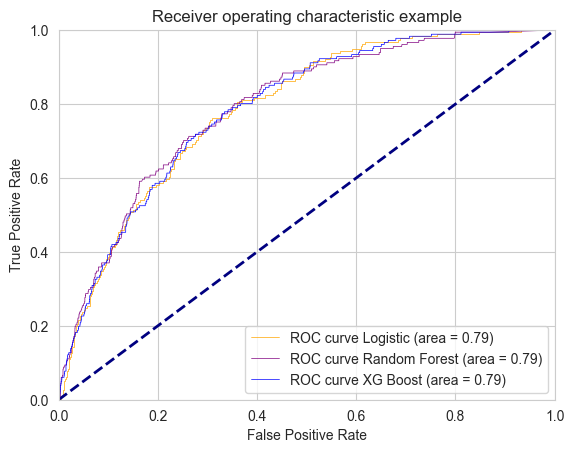

In [56]:
# Plot the ROC Curve
plt.figure()
lw = 2
plot_auc_line(log_search, 'orange', .5, "Logistic")
plot_auc_line(rf_search, 'purple', .5, "Random Forest")
plot_auc_line(xgb_search, 'blue', .5, "XG Boost")
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

#### Re-attempting modeling with the Feature Engineering above applied

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
X = df[['temp', 'pressure', 'temp_pressure', 'change_pressure', 'change_temp']]
y = df['isRain']
x_train, x_test, y_train,  y_test = train_test_split(X, y, random_state=123)

In [59]:
smote = SMOTE(sampling_strategy='auto', random_state=123)
x_train, y_train = smote.fit_resample(x_train, y_train)

pd.DataFrame(y_train).value_counts(normalize=True)

isRain
0         0.5
1         0.5
Name: proportion, dtype: float64

### Logistic Regression

In [60]:
import warnings
warnings.filterwarnings('ignore')


pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('logistic', LogisticRegression(random_state=123))
])

param_grid = {
    'poly__degree': [2,3],
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 200],
    'logistic__penalty': ['none', 'l1', 'l2']
}

log_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=4, verbose=1, scoring='f1')

log_search.fit(x_train, y_train)

# Print best parameters and score
print("Best parameters:", log_search.best_params_)
print("Best score:", log_search.best_score_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


/Users/laffer/Desktop/workspaces/FinalProject/RainSensorPrediction/projectenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/laffer/Desktop/workspaces/FinalProject/RainSensorPrediction/projectenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/laffer/Desktop/workspaces/FinalProject/RainSensorPrediction/projectenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/laffer/Desktop/workspaces/FinalProject/RainSensorPrediction/projectenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Sett

Best parameters: {'logistic__C': 1, 'logistic__penalty': 'l2', 'poly__degree': 3}
Best score: 0.8010143176522607


### Random Forest

In [61]:
%%time 

rfc = RandomForestClassifier(random_state=123)

# Define the pipeline with RFE
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('rfc', rfc)
])

ps = np.arange(4,12,2)
param_grid = {
    'poly__degree': [2,3],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_depth': ps,
    'rfc__min_samples_leaf': ps,
    'rfc__n_estimators': [20,40,80,100]
}

# Perform randomized search using the defined pipeline and parameter grid
rf_search = GridSearchCV(rf_pipeline, param_grid=param_grid, cv=5, scoring='f1',\
                                 n_jobs=6)

# Fit the search on the training data using the combined weights
rf_search.fit(x_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {rf_search.best_params_}")
print(f"Mean Accuracy score: {np.mean(rf_search.cv_results_['mean_test_score']).round(2)}")

Best parameters: {'poly__degree': 2, 'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 4, 'rfc__n_estimators': 100}
Mean Accuracy score: 0.84
CPU times: user 8.44 s, sys: 1.72 s, total: 10.2 s
Wall time: 13min 37s


### Extreme Gradient Boost

In [62]:
%%time 

xgb = XGBClassifier(random_state=123)

# Define the pipeline
xgb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('xgbc', xgb)
])

param_grid = {
    'poly__degree': [2,3],
    'xgbc__max_depth': np.arange(2,6,1),
    'xgbc__learning_rate': [.001, 0.01, 0.1],
    'xgbc__subsample': [0.3, 0.5, 0.7],
    'xgbc__colsample_bytree': [0.3, 0.5, 0.7],
    'xgbc__n_estimators': [20,40,80, 100,150, 200]
}

# random search using the defined pipeline and parameter grid
xgb_search = GridSearchCV(xgb_pipeline, param_grid=param_grid, cv=5, scoring='f1',\
                                  n_jobs=6)

# Fit the search on the training data using the combined weights
xgb_search.fit(x_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {xgb_search.best_params_}")
print(f"Best Accuracy score: {np.mean(xgb_search.cv_results_['mean_test_score']).round(2)}")


Best parameters: {'poly__degree': 3, 'xgbc__colsample_bytree': 0.5, 'xgbc__learning_rate': 0.1, 'xgbc__max_depth': 5, 'xgbc__n_estimators': 200, 'xgbc__subsample': 0.7}
Best Accuracy score: 0.83
CPU times: user 15.9 s, sys: 6.22 s, total: 22.1 s
Wall time: 8min 38s


### Evaluation

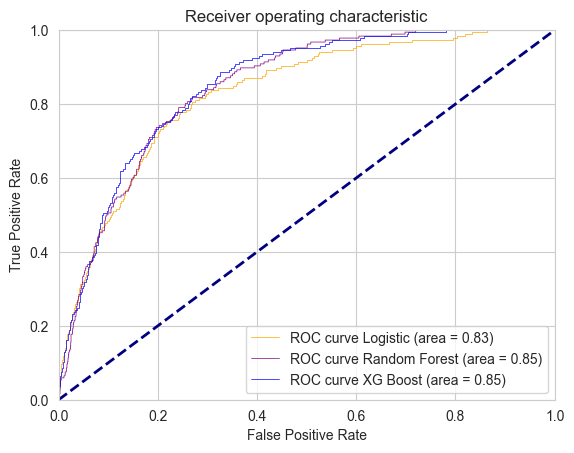

In [63]:
plt.figure()
lw = 2
plot_auc_line(log_search, 'orange', .5, "Logistic")
plot_auc_line(rf_search, 'purple', .5, "Random Forest")
plot_auc_line(xgb_search, 'blue', .5, "XG Boost")
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

In [64]:


y_prob = log_search.predict_proba(x_test)[:, 1]
y_pred = log_search.predict(x_test)
log_f1 = f1_score(y_test, y_pred)
log_accuracy = accuracy_score(y_test, y_pred)
log_auc_roc = roc_auc_score(y_test, y_prob)

y_prob = xgb_search.predict_proba(x_test)[:, 1]
y_pred = xgb_search.predict(x_test)
xg_f1 = f1_score(y_test, y_pred)
xg_accuracy = accuracy_score(y_test, y_pred)
xg_auc_roc = roc_auc_score(y_test, y_prob)

y_prob = rf_search.predict_proba(x_test)[:, 1]
y_pred = rf_search.predict(x_test)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_auc_roc = roc_auc_score(y_test, y_prob)

# accuracy = {'Logistic Regression':log_accuracy, 'XGBoost': xg_accuracy, 'Weighted Random Forest': rf_accuracy}

# f1 = {'Logistic Regression':log_f1, 'XGBoost': xg_f1, 'Weighted Random Forest': rf_f1}

# auc_roc = {'Logistic Regression':log_auc_roc, 'XGBoost': xg_auc_roc, 'Weighted Random Forest': rf_auc_roc}

accuracy = {'Logistic Regression':log_accuracy, 'Weighted Random Forest': rf_accuracy}

f1 = {'Logistic Regression':log_f1, 'Weighted Random Forest': rf_f1}

auc_roc = {'Logistic Regression':log_auc_roc, 'Weighted Random Forest': rf_auc_roc}

# Create dataframe with results
models = pd.DataFrame({'Accuracy': accuracy, 'F1 Score': f1, 'AUC ROC': auc_roc})
models = models.sort_values('Accuracy')
models.round(2)

,Accuracy,F1 Score,AUC ROC
Logistic Regression,0.74,0.23,0.83
Weighted Random Forest,0.82,0.26,0.85


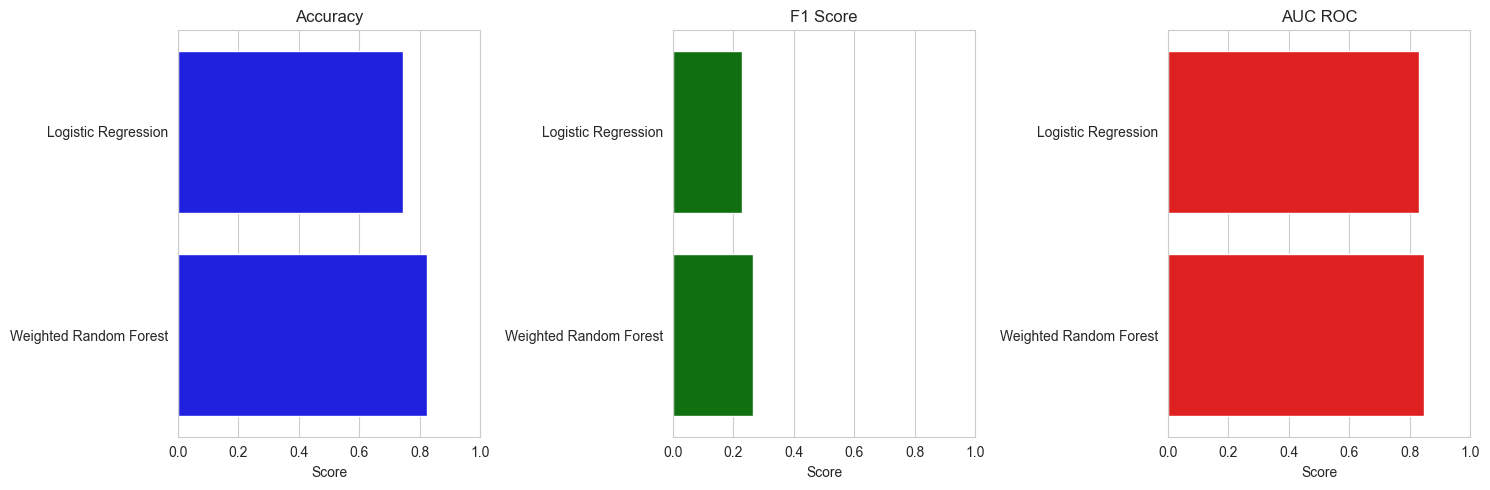

In [65]:
# plot accuracy scores
fig, axes = plt.subplots(ncols=3, figsize=(15,5))

models = models.sort_values('Accuracy')

sns.barplot(data=models, y=models.index, x='Accuracy', ax=axes[0], color="b")
axes[0].set(title='Accuracy', xlabel='Score', ylabel='')
axes[0].set_xlim([0, 1])

sns.barplot(data=models, y=models.index, x='F1 Score', ax=axes[1], color="g")
axes[1].set(title='F1 Score', xlabel='Score', ylabel='')
axes[1].set_xlim([0, 1])

sns.barplot(data=models, y=models.index, x='AUC ROC', ax=axes[2], color="r")
axes[2].set(title='AUC ROC', xlabel='Score', ylabel='')
axes[2].set_xlim([0, 1])

    
plt.tight_layout()
plt.show()


The Extreme Gradient Boosted algorithm performs better than the rest on all occasions. In this case it seems like the best model to proceed with however there is one metric that could influence our decision. Since this application is run on a smartwatch device, space, memory and, cpu are very important metrics. The logistic regession will be the most efficient for these scenarios but buy how much.

### Export to Core ML

The best models have been determined and now be converted to .mlmodel files that can be implemented in a Swift application.

In [66]:
random_forest = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, n_estimators=100)


random_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4)

In [67]:
import coremltools as cml
forest_pipeline.multi_class = 'ovr'
forest_model = cml.converters.sklearn.convert(random_forest, ['temp', 'pressure', 'temp_pressure', 'change_pressure', 'change_temp'], 'isRain')

# Assign model metadata
forest_model.author = "Ryan Lafferty"
forest_model.license = "MIT"
forest_model.short_description = \
"Predicts Weather it is Raining using a Random Forest Model"

# Assign feature descriptions
forest_model.input_description["temp"] = \
"Current Temperature"

forest_model.input_description["pressure"] = \
"Current Barometric pressure"

forest_model.input_description["temp_pressure"] = \
"Polynomial Effect between curren temperature and barometric pressure"

forest_model.input_description["change_pressure"] = \
"Change from previous pressure"

forest_model.input_description["change_temp"] = \
"Change in temperature"


forest_model.output_description["isRain"] = \
"Change in rain"

forest_model.save('forest_rain_prediction.mlmodel')

ModuleNotFoundError: No module named 'coremltools'

In [ ]:
lr = LogisticRegression(C=.001)
lr.fit(x_train, y_train)


LogisticRegression(C=0.001)

In [ ]:
lr.multi_class = 'ovr'
logisticRegressionModel = cml.converters.sklearn.convert(lr, ['temp', 'pressure', 'temp_pressure', 'change_pressure', 'change_temp'], 'isRain')

# Assign model metadata
logisticRegressionModel.author = "Ryan Lafferty"
logisticRegressionModel.license = "MIT"
logisticRegressionModel.short_description = \
"Predicts Weather it is Raining using Logistic Regression"

# Assign feature descriptions
logisticRegressionModel.input_description["temp"] = \
"Current Temperature"

logisticRegressionModel.input_description["pressure"] = \
"Current Barometric pressure"

logisticRegressionModel.input_description["temp_pressure"] = \
"Polynomial Effect between curren temperature and barometric pressure"

logisticRegressionModel.input_description["change_pressure"] = \
"Change from previous pressure"

logisticRegressionModel.input_description["change_temp"] = \
"Change in temperature"


logisticRegressionModel.output_description["isRain"] = \
"Change in rain"

logisticRegressionModel.save('logisticRegressionModel.mlmodel')

In [ ]:
df.describe()

,datetime,temp,prec,pressure,isRain,temp_pressure,previous_temp,previous_pressure,change_temp,change_pressure,pressure_binary
count,15337,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000,15337.000000
mean,2022-11-16 13:00:00,13.382819,0.058095,1018.375843,0.047076,59.719741,13.382338,1018.376091,0.000481,-0.000248,0.545543
min,2022-01-01 01:00:00,-7.200000,0.000000,986.100000,0.000000,21.987347,-7.200000,986.100000,-5.620000,-2.800000,0.000000
25%,2022-06-09 19:00:00,6.980000,0.000000,1013.900000,0.000000,36.870944,6.980000,1013.900000,-0.560000,-0.300000,0.000000
50%,2022-11-16 13:00:00,13.230000,0.000000,1018.000000,0.000000,47.482550,13.230000,1018.000000,-0.060000,0.000000,1.000000
75%,2023-04-25 07:00:00,19.360000,0.000000,1022.400000,0.000000,67.085261,19.360000,1022.400000,0.560000,0.300000,1.000000
max,2023-10-02 01:00:00,37.640000,8.000000,1041.900000,1.000000,1009.300000,37.640000,1041.900000,3.780000,5.500000,1.000000
std,NaN,8.570332,0.293296,7.654133,0.211808,44.109466,8.570512,7.654396,1.088020,0.480986,0.497938


In [100]:
metrics =  ['Size KB', 'Prediction Time MS', 'Load Time MS', 'Max CPU %', 'Max Memory MB', 'Build Size MB']
logistic_regression = [3, .02, .37, 10,  17.6, 36.4]
random_forest = [826, .01, .52, 18, 17.6, 37.2]

In [101]:
metric_df = pd.DataFrame([metrics, logistic_regression, random_forest]).T
metric_df.columns = ['Metrics', 'Logistic Regression', 'Random Forest']
metric_df

,Metrics,Logistic Regression,Random Forest
0,Size KB,3,826
1,Prediction Time MS,0.02,0.01
2,Load Time MS,0.37,0.52
3,Max CPU %,10,18
4,Max Memory MB,17.6,17.6
5,Build Size MB,36.4,37.2


In [102]:
metric_df = metric_df.melt(id_vars=['Metrics'])
metric_df.columns = ['Metric', 'Model', 'Value']
metric_df

,Metric,Model,Value
0,Size KB,Logistic Regression,3
1,Prediction Time MS,Logistic Regression,0.02
2,Load Time MS,Logistic Regression,0.37
3,Max CPU %,Logistic Regression,10
4,Max Memory MB,Logistic Regression,17.6
5,Build Size MB,Logistic Regression,36.4
6,Size KB,Random Forest,826
7,Prediction Time MS,Random Forest,0.01
8,Load Time MS,Random Forest,0.52
9,Max CPU %,Random Forest,18


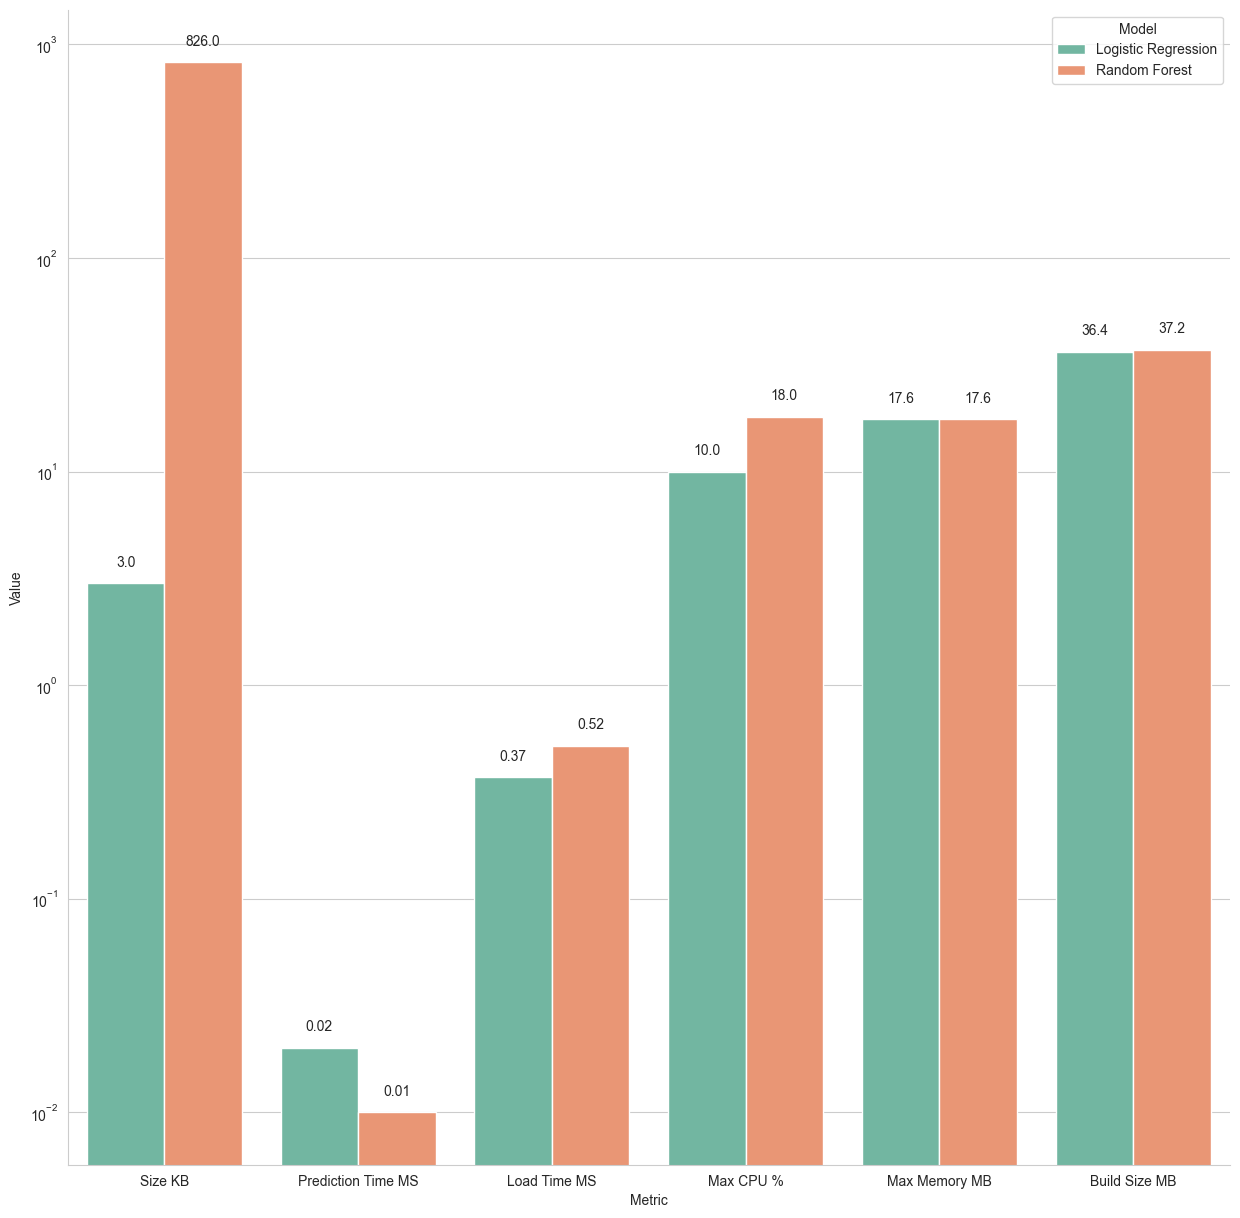

In [103]:
plt.figure(figsize=(15,15))
ax = sns.barplot(data = metric_df, x = "Metric", y = "Value", hue = 'Model')
plt.yscale('log')

sns.despine()
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=10, labels=[f'{(val):,}' for val in i.datavalues])